In [1]:
import sqlite3
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def load_data():
    DB_PATH=r"..\data\posts_infos.sqlite"
    with sqlite3.connect(DB_PATH) as connection:
        return pd.read_sql_query("SELECT * from posts_infos", connection)

df = load_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         119 non-null    object 
 1   gross_salary      106 non-null    float64
 2   net_salary        105 non-null    float64
 3   experience        109 non-null    float64
 4   working_hours     106 non-null    float64
 5   teleworking_days  97 non-null     float64
 6   holidays          103 non-null    float64
 7   ecocheques        78 non-null     float64
 8   education         105 non-null    object 
 9   employees_amount  100 non-null    float64
dtypes: float64(8), object(2)
memory usage: 9.4+ KB


In [4]:
df.describe()

,gross_salary,net_salary,experience,working_hours,teleworking_days,holidays,ecocheques,employees_amount
count,106.000000,105.000000,109.000000,106.000000,97.000000,103.000000,78.000000,100.000000
mean,3902.141509,2648.114286,3.738532,38.896226,4.969072,26.155340,233.794872,6029.930000
std,1023.351277,501.506199,2.863141,1.393381,14.717092,6.355108,57.813484,15131.825794
min,2300.000000,1940.000000,0.000000,35.000000,0.000000,18.000000,0.000000,5.000000
25%,3212.500000,2300.000000,1.500000,38.000000,2.000000,20.000000,250.000000,60.000000
50%,3700.000000,2550.000000,3.000000,39.000000,2.000000,25.000000,250.000000,500.000000
75%,4400.000000,2800.000000,5.000000,40.000000,3.000000,32.000000,250.000000,5000.000000
max,7200.000000,4500.000000,14.000000,45.000000,100.000000,45.000000,280.000000,100000.000000


In [5]:
df.loc[df["teleworking_days"] > 5, "teleworking_days"] = pd.NA

In [6]:
regex_patterns = {
    'master': r'(m[sc][sc]?)|(master)', 
    'phd': r'p[hd][hd]', 
    'bachelor': r'(b[sc][sc])|(bachelor)|(graduaa?t)'
}
for grade, pattern in regex_patterns.items():
    df["education"] = df["education"].str.replace(re.compile(pattern, flags=re.IGNORECASE), grade, regex=True)

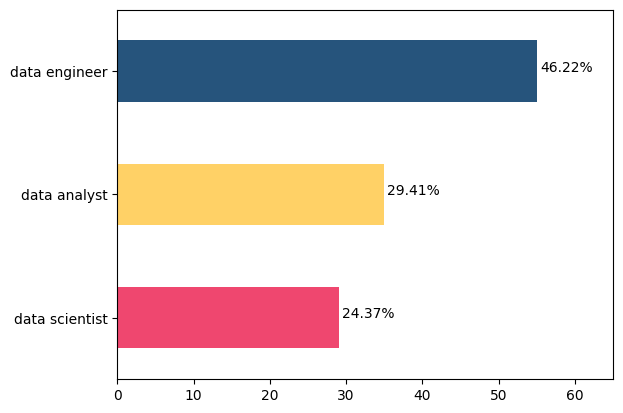

In [7]:
def job_distribution(df):
    X = df.groupby(["job_title"])["job_title"].count()
    X.sort_values(ascending=True, inplace=True)
    total = X.sum()

    colors = ["#ef476f", "#ffd166", "#26547c"]
    with plt.style.context("default"):
        _, ax = plt.subplots()
        X.plot(kind="barh", color=colors, ax=ax)
        ax.set_ylabel("")
        for group, val in enumerate(X):
            ax.text(val + 0.4, group, f"{val/total:.2%}")
        ax.set(xlim=(0, 65))
        plt.show()


job_distribution(df)

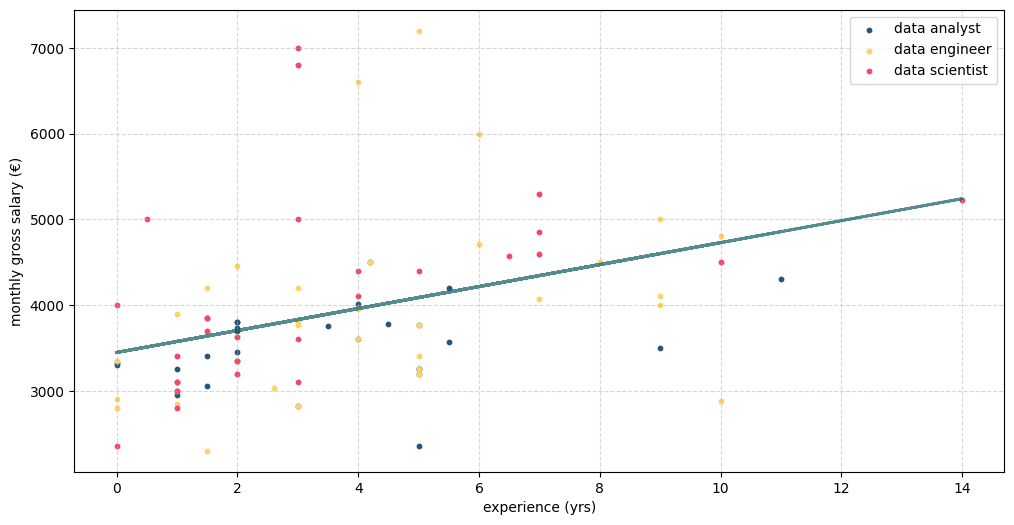

In [8]:
def salary_on_experience_regression(df):
    X = df[["experience", "gross_salary"]].dropna()
    Y = X.pop("gross_salary")
    X = X.values.reshape(-1, 1)
    Y = Y.values.reshape(-1, 1)
    reg = linear_model.LinearRegression()
    reg.fit(X, Y)

    colors = {
        "data analyst": "#26547c",
        "data engineer": "#ffd166",
        "data scientist": "#ef476f",
        "reg_line": "#1b646b",
    }
    with plt.style.context("default"):
        _, ax = plt.subplots(figsize=(12,6))
        for group, df in df.groupby("job_title"):
            ax.scatter(df.experience, df.gross_salary, s = 10, c=colors[group], label=group)
        ax.plot(
            X,
            reg.predict(X),
            linewidth=2,
            color=colors["reg_line"],
            alpha=0.75,
        )
        ax.legend()
        ax.set_xlabel("experience (yrs)")
        ax.set_ylabel("monthly gross salary (€)")
        ax.grid(linestyle="--", alpha=0.5)
        plt.show()

salary_on_experience_regression(df)

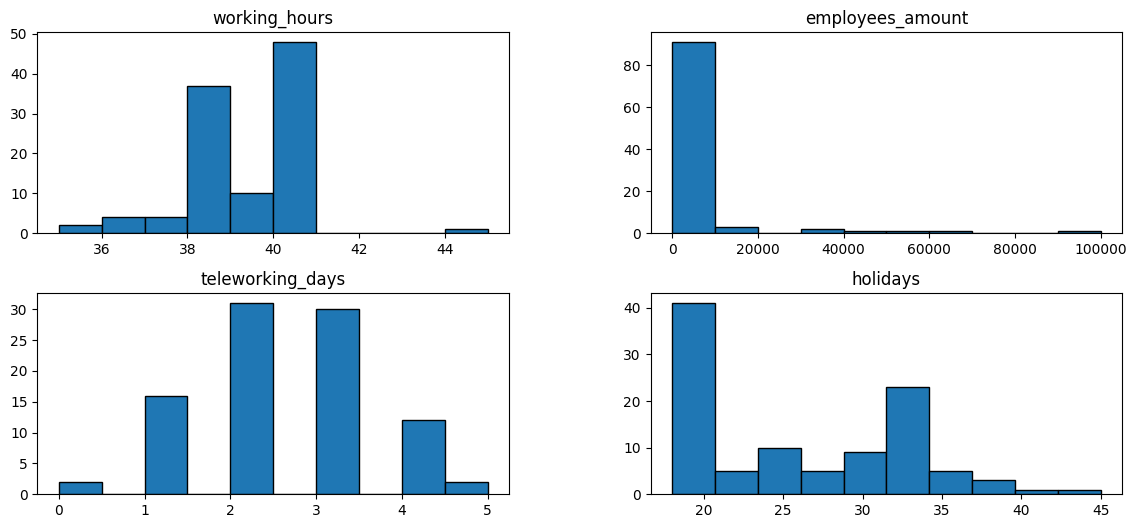

In [9]:
def some_distributions(df):
    cols = ['working_hours', 'employees_amount', 'teleworking_days', 'holidays']
    X = df[cols]

    _, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,6))
    X.hist(ax=ax.flatten(), edgecolor='black', grid=False)
    plt.show()

some_distributions(df)

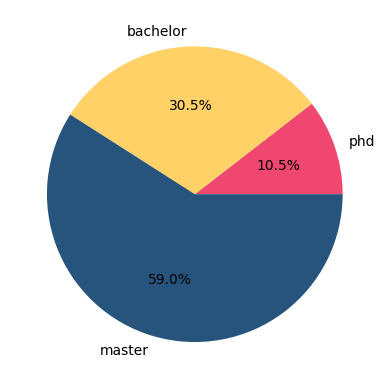

In [10]:
def highest_education(df):
    X = df.groupby(['education'])['education'].count()
    X.sort_values(inplace=True)
    
    colors = ["#ef476f", "#ffd166", "#26547c"]
    _, ax = plt.subplots()
    X.plot(kind='pie', colors=colors, labels=X.index, autopct='%1.1f%%')
    ax.set_ylabel("")
    plt.show()

highest_education(df)